In [14]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database, save_database, filter_data
# Set up the system path to include parent directory
sys.path.append('../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)

def load_rules(rules_path, formula_key='Composition', element_key='C', min_count=0, max_count=0):
    """
    Loads and filters a set of rules from a specified path based on the given parameters.

    The function first loads a database of rules from the given path. It then filters 
    this data based on the specified element's count within a chemical formula.

    Parameters:
    - rules_path: str
        The file path to the rules database to be loaded.
    - formula_key: str, optional (default='Composition')
        The key in the database that corresponds to the chemical composition.
    - element_key: str, optional (default='C')
        The specific element to focus on within the chemical compositions.
    - min_count: int, optional (default=0)
        The minimum count of the specified element in a composition for a rule to be included.
    - max_count: int, optional (default=0)
        The maximum count of the specified element in a composition for a rule to be included.
        A value of 0 indicates no upper limit.

    Returns:
    - list or DataFrame
        The filtered set of rules based on the specified element counts within their compositions.
    """
    rules = load_database(rules_path)
    rules = filter_data(rules, unbalance_values=None, formula_key=formula_key, element_key=element_key, 
                        min_count=min_count, max_count=max_count)
    return rules


def main():
    """
    Main function to execute script tasks.
    """
    configure_logging()

    # Load data
    data_file_path = '../Data/USPTO_50k.csv'
    df = load_data(data_file_path)

    # Display the first few rows of the DataFrame
    display(df.head())

    # Print the number of rows in the DataFrame
    print(f"Number of rows in the dataset: {len(df)}")

    # Load rules
    rules = load_rules('../Data/automatic_rules.json.gz')
    print('Number of rules: ', len(rules))

    return df, rules


if __name__ == "__main__":
    df, rules = main()

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


Number of rows in the dataset: 50016
Number of rules:  56


# **1. USPTO predcition**

## 1.1. Preprocessing

In [34]:
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.rsmi_utils import  load_database

rule_manager_pathname = '../Data/rule_manager.json.gz'
input_data = df


def process_reactions(input_data):
    """
    Process and rebalance reactions based on the provided input data.

    Parameters:
    input_data (str, list of dict, or pd.DataFrame): Input data containing reaction SMILES.

    Returns:
    dict: Dictionary containing the rebalanced reaction information.
    """
    if isinstance(input_data, str):
        input_data = [{'reactions': input_data}]
    elif isinstance(input_data, pd.DataFrame):
        if 'reactions' not in input_data.columns:
            raise ValueError("DataFrame must contain a 'reactions' column.")
        input_data = input_data.to_dict('records')
    elif not isinstance(input_data, list):
        raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

    # Step 1: Process the input data
    process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=4, save_json=False)
    input_dict = process.data_splitter().to_dict('records')

    # Step 2: Decompose the reactions
    decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                                parallel=True, n_jobs=4, verbose=1)
    react_dict, product_dict = decompose.data_decomposer()

    # Step 3: Compare reactants and products
    comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=4)
    unbalance, diff_formula = comp.run_parallel()

    # Step 4: Combine the results into a dictionary
    reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                    pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                    pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                axis=1)
    #reactions_clean = reactions_clean[(reactions_clean['Unbalance'] == 'Reactants')|(reactions_clean['Unbalance'] == 'Products')]   
    reactions_clean = reactions_clean.to_dict(orient='records')

    return reactions_clean

In [35]:
reactions_clean=process_reactions(input_data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 49165 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: 

In [33]:
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side: ', len(no_C_reactions))


un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side: ', len(un_C_reactions))


both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions: ', len(both_side_reactions))


balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions: ', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side:  32100
Number of Carbon Reactions Unbalanced in one side:  13752
Number of Both sides Unbalanced Reactions:  3088
Number of Balanced Reactions:  1076


## 1.2. Rule-Based Rebalance

For no_C_reactions 

In [ ]:
import logging
import sys
from rdkit import Chem, RDLogger
import rdkit
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import extract_results_by_key

# Configure RDKit logging to suppress warning messages and log errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Set up a logger for RDKit to capture its log messages
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))
rdkit_logger.setLevel(logging.ERROR)

# Initialize a SyntheticRuleImputer instance with specified parameters
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')

# Perform parallel imputation based on filtered data
expected_result = imp.parallel_impute(filter_data)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)

# Display the number of solved and unsolved cases
print('Solved:', len(solve))
print('Unsolved:', len(unsolve))


## 1.3. MCS-Based Rebalance

In [42]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs
filtered_data = un_C_reactions + both_side_reactions  + unsolve

In [51]:
save_database(filtered_data, '../Data/Unsolved_reactions.csv')
filtered_data = load_database('../Data/Unsolved_reactions.csv')
filtered_data

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20110224204A1',
  'class': 3,
  'reactions': 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1>>N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1',
  'reactants': 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1',
  'products': 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 6, 'O': 2, 'B': 1, 'Br': 1, 'H': 12}},
 {'id': 'US20110263607A1',
  'class': 6,
  'reactions': 'CC(C)(C)OC(=O)CONC(=O)NCc1cccc2ccccc12>>O=C(O)CONC(=O)NCc1cccc2ccccc12',
  'reactants': 'CC(C)(C)OC(=O)CONC(=O)NCc1cccc2

In [46]:
def single_impute(data_dict, params=None):
    """
    Performs imputation on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing imputation results and any issues encountered.
    """
    from rdkit import Chem
    from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
    from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

    impute_dict = {'impute_product_smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, product_mol = analyzer.fit(data_dict, params=params)
        impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
        impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]

        impute_dict['impute_product_smiles'] = impute_product_smiles
        impute_dict['boundary_atoms_products'] = boundary_atoms_products
        impute_dict['nearest_neighbor_products'] = nearest_neighbor_products

    except Exception as e:
        impute_dict['issue'] = data_dict

    return impute_dict


In [47]:
final = Parallel(n_jobs=8)(delayed(single_impute)(data_dict) for data_dict in filtered_data[:100])

[14:52:57] non-ring atom 3 marked aromatic
[14:52:57] non-ring atom 4 marked aromatic


In [48]:
final

[{'impute_product_smiles': ['O=COCc1ccccc1'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'N': 9}]],
  'issue': []},
 {'impute_product_smiles': ['CC1(C)OBOC1(C)C', 'Br'],
  'boundary_atoms_products': [[{'B': 4}], [{'Br': 0}]],
  'nearest_neighbor_products': [[{'C': 5}], [{'C': 13}]],
  'issue': []},
 {'impute_product_smiles': ['CC(C)C'],
  'boundary_atoms_products': [[{'C': 1}]],
  'nearest_neighbor_products': [[{'O': 4}]],
  'issue': []},
 {'impute_product_smiles': ['COc1ccc(C)cc1'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'N': 8}]],
  'issue': []},
 {'impute_product_smiles': ['C'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'O': 1}]],
  'issue': []},
 {'impute_product_smiles': ['Cc1ccccc1'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'N': 17}]],
  'issue': []},
 {'impute_product_smiles': ['C[Si](C)C'],
  'boundary_atoms_products': [[{'Si': 1}]],
  

In [6]:
id = 1
input = 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'
input_df = pd.DataFrame([{'id': id, 'reactions': input}])
input_df

,id,reactions
0,1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...


In [8]:
process=RSMIProcessing(data = input_df, rsmi_col='reactions',parallel=True, n_jobs=-1, 
                       save_json= False,)
input_dict = process.data_splitter().to_dict('records')



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [9]:
decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


# **2. Streamlit deploy**

not complete

In [29]:
import streamlit as st
import pandas as pd
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import load_database

class RebalancingReaction:
    def __init__(self, rule_manager_pathname):
        self.rules = load_database(pathname=rule_manager_pathname)

    def process_reactions(self, input_data):
        if isinstance(input_data, str):
            input_data = [{'reactions': input_data}]
        elif isinstance(input_data, pd.DataFrame):
            if 'reactions' not in input_data.columns:
                raise ValueError("DataFrame must contain a 'reactions' column.")
        elif not isinstance(input_data, list):
            raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

        if isinstance(input_data, pd.DataFrame):
            input_data = input_data.rename(columns={'reactions': 'reactants'})

        process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=-1, save_json=False)
        input_dict = process.data_splitter().to_dict('records')

        decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                                  parallel=True, n_jobs=-1, verbose=1)
        react_dict, product_dict = decompose.data_decomposer()

        comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=-1)
        unbalance, diff_formula = comp.run_parallel()

        reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                     pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                     pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                    axis=1).to_dict(orient='records')

        imp = SyntheticRuleImputer(rule_dict=self.rules)
        dict_impute = imp.impute(missing_dict=reactions_clean[0:1])

        return dict_impute

# Create a Streamlit app
st.title("Reaction Rebalancing App")

# Sidebar
st.sidebar.header("Settings")
rule_manager_path = st.sidebar.text_input("Rule Manager Path:", "./Data/rule_manager.json.gz")
reaction_input = st.sidebar.text_area("Input Reaction:", "")
input_data_list = st.sidebar.text_area("Input Data (JSON format):", "")
input_data = []

if reaction_input:
    input_data.append({'reactions': reaction_input})

if input_data_list:
    input_data.extend(pd.read_json(input_data_list).to_dict('records'))

rebalancer = RebalancingReaction(rule_manager_path)

# Main content
if st.button("Process Reactions"):
    if not input_data:
        st.warning("Please provide reaction data.")
    else:
        result = rebalancer.process_reactions(input_data)
        st.subheader("Rebalanced Reaction:")
        st.write(result)

# Display the input data for reference
st.subheader("Input Data:")
st.write(input_data)


2023-11-26 22:48:59.457 
  command:

    streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/cheminfo/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
import pandas as pd
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import load_database
from SynRBL.SynVis import ReactionVisualizer

def synthesize_reactions(input_data):
    if isinstance(input_data, str):
        input_data = [{'reactions': input_data}]
    elif isinstance(input_data, pd.DataFrame):
        if 'reactions' not in input_data.columns:
            raise ValueError("DataFrame must contain a 'reactions' column.")
        input_data = input_data.to_dict('records')
    elif not isinstance(input_data, list):
        raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

    # Step 1: Process the input data
    process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=-1, save_json=False)
    input_dict = process.data_splitter().to_dict('records')

    # Step 2: Decompose the reactions
    decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                              parallel=True, n_jobs=-1, verbose=1)
    react_dict, product_dict = decompose.data_decomposer()

    # Step 3: Compare reactants and products
    comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=-1)
    unbalance, diff_formula = comp.run_parallel()

    # Step 4: Combine the results into a dictionary
    reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                 pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                 pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                axis=1).to_dict(orient='records')

    # Step 5: Load rule database
    rules = load_database(pathname='./Data/rule_manager.json.gz')

    # Step 6: Impute missing data
    imp = SyntheticRuleImputer(rule_dict=rules)
    dict_impute = imp.impute(missing_dict=reactions_clean[0:1])

    return dict_impute

# Example with a list of dictionaries containing reaction SMILES
input_data_list = [{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
                   {'reactions': 'CC>>C[C@H](O)c1ccccc1'},
                   {'reactions': 'CCO>>C[C@H](O)c1ccccc1.CCO'}]
result_list = synthesize_reactions(input_data_list)
print(result_list)

# Example usage with the provided input data
visualizer = ReactionVisualizer(compare=True, orientation='vertical', figsize=(12, 6), label_position='above', dpi=300)
visualizer.plot_reactions(result_list[0]['reactions'], result_list[0]['new_reaction'])



In [24]:
# Example with a list of dictionaries containing reaction SMILES
input_data_list = [{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
                   {'reactions': 'CC>>C[C@H](O)c1ccccc1'},
                   {'reactions': 'CCO>>C[C@H](O)c1ccccc1.CCO'}]
result_list = synthesize_reactions(input_data_list)
print(result_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1', 'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1', 'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]', 'Unbalance': 'Products', 'Diff_formula': {'O': 1, 'H': 2, 'Q': 0}, 'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]'}]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [26]:
result_list[0]

{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
 'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
 'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]',
 'Unbalance': 'Products',
 'Diff_formula': {'O': 1, 'H': 2, 'Q': 0},
 'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]'}

In [25]:
from SynRBL.SynVis import ReactionVisualizer

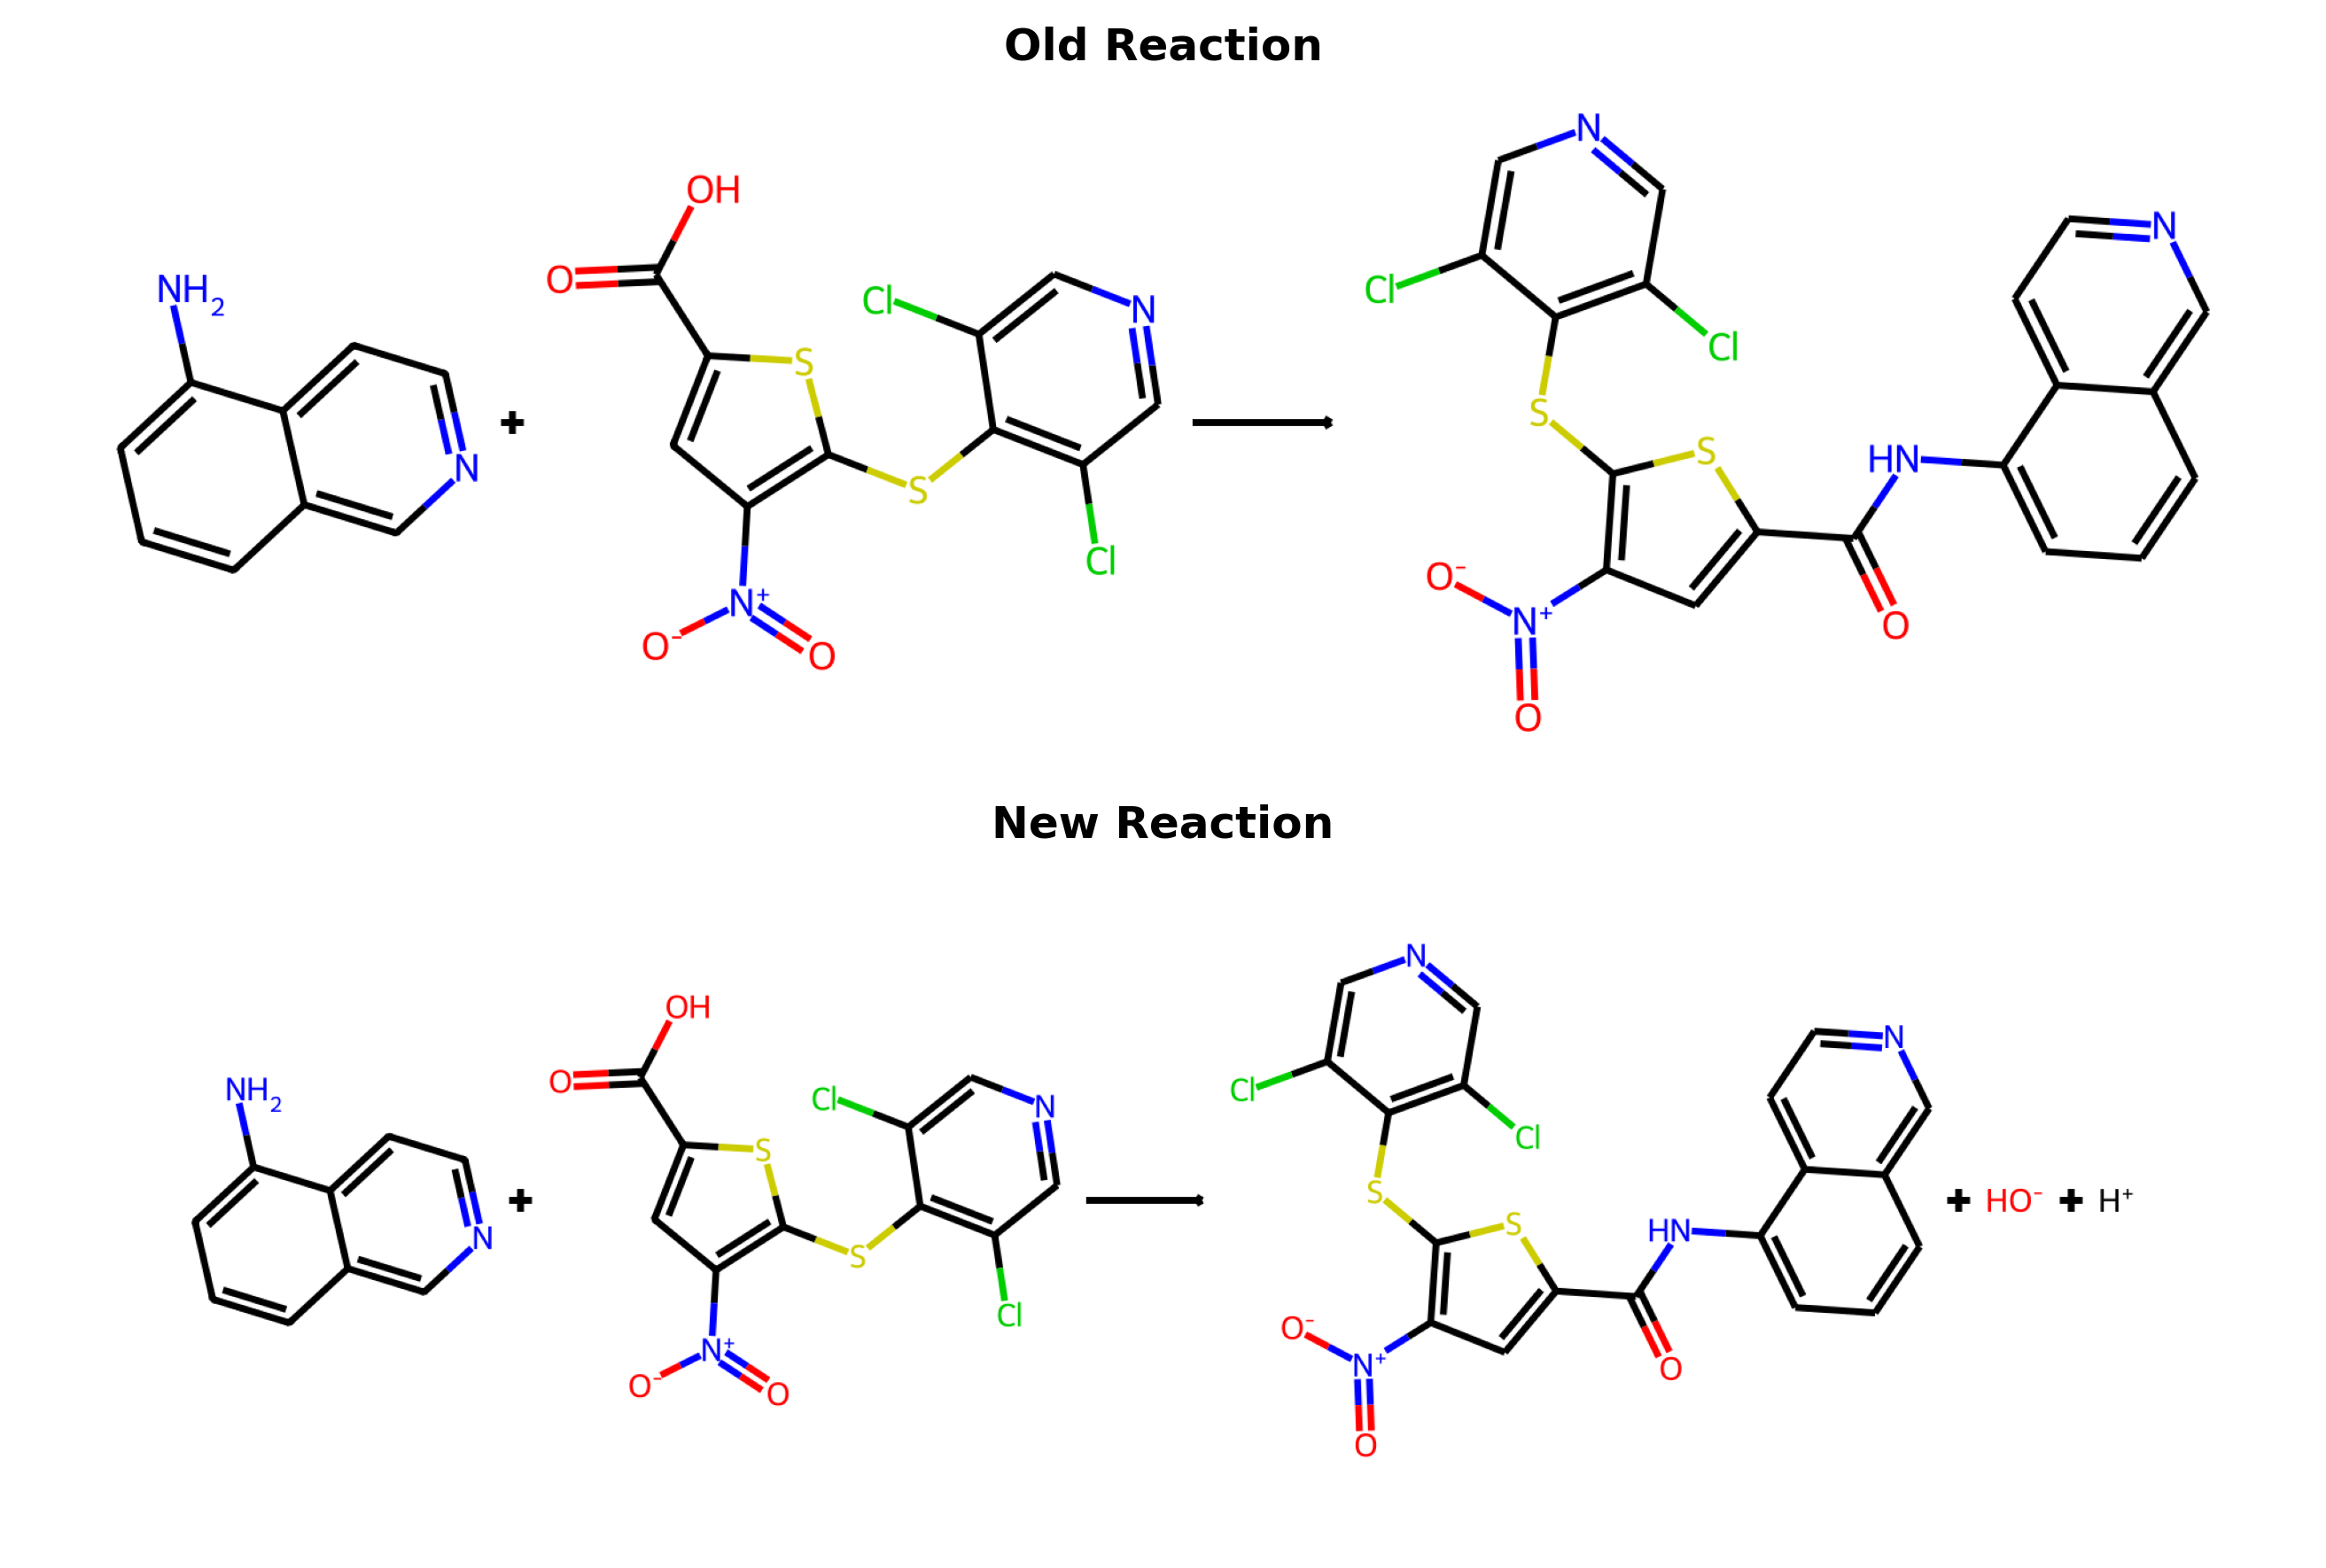

In [27]:
# Example usage with the provided input data
visualizer = ReactionVisualizer(compare=True, orientation='vertical', figsize=(12, 6), label_position='above', dpi=300)
visualizer.plot_reactions(result_list[0]['reactions'], result_list[0]['new_reaction'])
